<a href="https://colab.research.google.com/github/juanazorzolo/TP2-AA2-HerreraM-NardiG-ZorzoloJ/blob/main/ej_1_tp2_AAII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 2 AAII 2025 - Redes Recurrentes y Reinforcement Learning



PROBLEMA 1 -GRUPO N° 5

Autores:

- Herrera Morena (H-1187/8)

- Nardi Gianella Belén (N-1277/7)

- Zorzolo Rubio Juana (Z-1217/3)

Objetivo: construir un modelo de clasificación utilizando redes neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Se deben entrenar y evaluar modelos utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.


## Importaciones

In [ ]:
import os
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import tensorflow_datasets as tfds
from IPython.display import Audio, display as ipy_display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Carga de datos

In [ ]:
# Cargar el dataset con división 80% train y 20% validación
(df_train, df_val), df_info = tfds.load('spoken_digit', split=['train[:80%]', 'train[80%:]'], with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/spoken_digit/incomplete.VXN76X_1.0.9/spoken_digit-train.tfrecord*...:   0%…

Dataset spoken_digit downloaded and prepared to /root/tensorflow_datasets/spoken_digit/1.0.9. Subsequent calls will reuse this data.


In [ ]:
# Obtener nombres de clases
label_names = np.array(df_info.features["label"].names)
print("Clases disponibles:", label_names)

# Mostrar cantidad real de ejemplos en cada subset
print("Ejemplos en df_train:", tf.data.experimental.cardinality(df_train).numpy())
print("Ejemplos en df_val:",   tf.data.experimental.cardinality(df_val).numpy())

# Mostrar ejemplos de df_train
for audio, label in df_train.take(3):
    print(f"Label: {label.numpy()} ({label_names[label.numpy()]})")
    print(f"Forma del audio: {audio.shape}")

Clases disponibles: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
Ejemplos en df_train: 2000
Ejemplos en df_val: 500
Label: 2 (2)
Forma del audio: (1525,)
Label: 1 (1)
Forma del audio: (2929,)
Label: 9 (9)
Forma del audio: (6457,)


## Preprocesamiento y Análisis de datos (EDA)

In [ ]:
# recorremos los audios y creamos un DataFrame con su información

audios = []
labels = []

for audio, label in df_train:
    audios.append(audio.numpy())
    labels.append(label.numpy())

data = []

for audio, label in df_train:
    arr = audio.numpy()
    data.append({
        'clase': label.numpy(),
        'duracion_muestras': len(arr),
        'media': np.mean(arr),
        'std': np.std(arr),
        'max': np.max(arr),
        'min': np.min(arr)
    })

df = pd.DataFrame(data)

In [ ]:
df.head()

,clase,duracion_muestras,media,std,max,min
0,2,1525,-225.447869,1056.924425,2560,-3072
1,1,2929,-248.396040,1555.141301,5376,-8448
2,9,6457,-0.236952,369.355777,1468,-1119
3,9,3360,-1.070536,340.482869,1264,-2111
4,7,2746,-232.786599,1588.794435,7680,-7936


Datos obtenidos hasta ahora:


*   hay 9 clases disponibles
*   hay 2000 datos de train y 500 de validación
*   duración de las muestras de audio
*   mín y max son métricas del array de numpy para ese audio




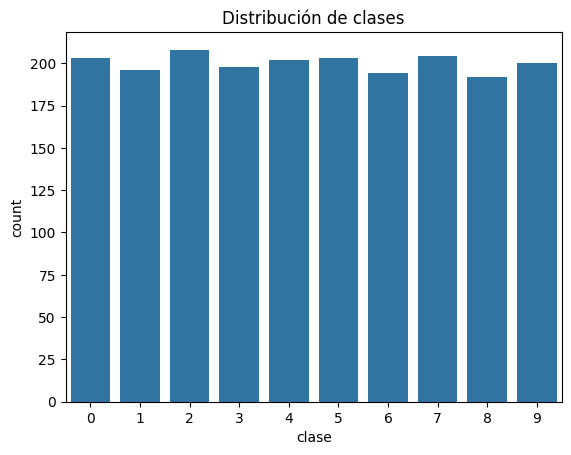

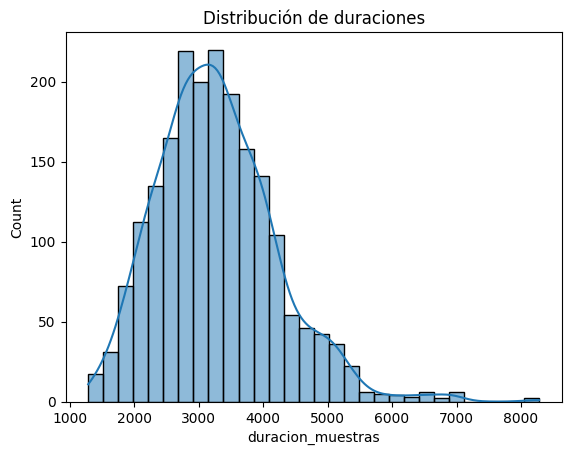

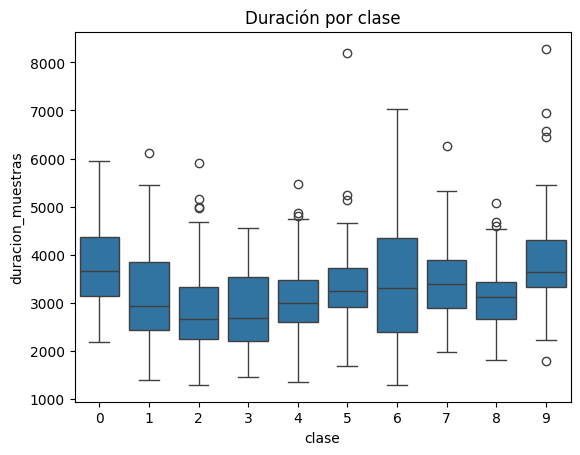

In [ ]:
# Distribución de clases
sns.countplot(x='clase', data=df)
plt.title("Distribución de clases")
plt.show()

# Distribución de duración
sns.histplot(df['duracion_muestras'], bins=30, kde=True)
plt.title("Distribución de duraciones")
plt.show()

# Boxplot por clase
sns.boxplot(x='clase', y='duracion_muestras', data=df)
plt.title("Duración por clase")
plt.show()


Conclusión:

Distribución de clases (Gráfico 1):

Muestra una distribución medianamente balanceada de las clases (0 a 9). Confirmamos que no hay gran desbalance en la cantidad de muestras por clase.

Distribución de duraciones (Gráfico 2):

Podemos observar la distribución general de la duración de los audios. Vemos una asimetría positiva (cola hacia la derecha), la distribución se asemeja a una normal.

Boxplot por clase (Gráfico 3):

Nos permite ver la mediana, los cuartiles y los posibles outliers de duración por cada dígito.
Detectamos si hay clases con duraciones anómalas o diferentes en promedio.


In [ ]:
# Mostrar y reproducir los primeros 3 audios
for i, (audio, label) in enumerate(df_train.take(3)):
    print(f"Ejemplo {i+1} - Dígito: {label.numpy()}")
    ipy_display(Audio(audio.numpy(), rate=16000))  # Asumimos sample rate de 16kHz

Ejemplo 1 - Dígito: 2


Ejemplo 2 - Dígito: 1


Ejemplo 3 - Dígito: 9


In [ ]:
# Mostrar y reproducir los primeros 3 audios
for i, (audio, label) in enumerate(df_val.take(3)):
    print(f"Ejemplo {i+1} - Dígito: {label.numpy()}")
    ipy_display(Audio(audio.numpy(), rate=16000))  # Asumimos sample rate de 16kHz

Ejemplo 1 - Dígito: 6


Ejemplo 2 - Dígito: 8


Ejemplo 3 - Dígito: 4


## Squeeze
Para normalizar y llevar todos los audios a 8000hz (en la página de tensorflow dice que todos están en esa frecuencia)

In [ ]:
LONG_HZ = 8000  # 1 segundo a 8kHz

def squeeze(audio, label):
    """
    Normaliza la señal de audio, elimina dimensiones extra y ajusta su longitud a LONG_HZ.
    - Convierte a float32 en [-1, 1]
    - Quita cualquier dimensión extra (como [N,1] -> [N])
    - Si el audio es más corto, hace padding con ceros.
    - Si es más largo, lo recorta a LONG_HZ.
    """
    # 1) Convertir a float32 y normalizar
    audio = tf.cast(audio, tf.float32) / 32768.0

    # 2) Asegurar forma 1D
    audio = tf.reshape(audio, [-1])  # más robusto que tf.squeeze

    # 3) Ajustar la longitud
    audio_len = tf.shape(audio)[0]
    audio = tf.cond(
        audio_len < LONG_HZ,
        lambda: tf.pad(audio, [[0, LONG_HZ - audio_len]]),
        lambda: audio[:LONG_HZ]
    )

    return audio, label

In [ ]:
df_train = df_train.map(squeeze, num_parallel_calls=AUTOTUNE)
df_val = df_val.map(squeeze, num_parallel_calls=AUTOTUNE)

In [ ]:
for audio, label in df_train.take(1):
    print("Forma del audio:", audio.shape)  # (8000,)
    print("Etiqueta:", label.numpy())

Forma del audio: (8000,)
Etiqueta: 2


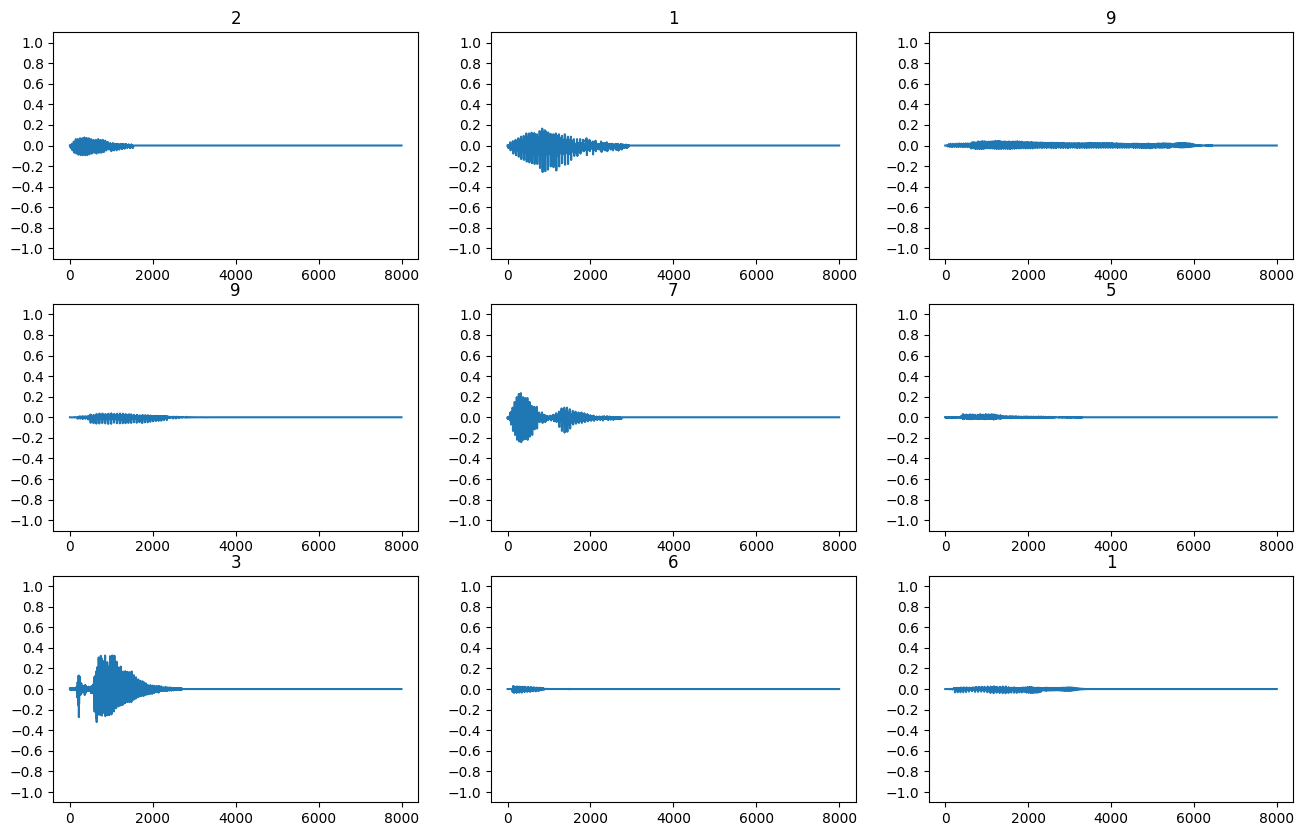

In [ ]:
# plotear forma de onda para algunos ejemplos

plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols

audios = []
labels = []

for audio, label in df_train.take(n):
    audios.append(audio.numpy())
    labels.append(label.numpy())

for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.plot(audios[i])
    plt.title(label_names[labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

plt.show()

## Convertir a espectogramas para modelo convolucional

se transforman las formas de onda de **señales del dominio del tiempo** a **señales del dominio tiempo-frecuencia** al calcular la transformada de Fourier de corto tiempo (STFT) para convertir las formas de onda en espectrogramas, que muestran cambios de frecuencia a lo largo del tiempo y pueden ser representados como imágenes 2D.

In [ ]:
def get_spectrogram(waveform):
  # Convierte la forma de onda en espectograma mediante STFT
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtiene la maginitud de STFT
  spectrogram = tf.abs(spectrogram)
  # agrega un canal a la dimensión para que el espectograma se pueda usar
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # logaritmo para mejor visualización
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec, shading='gouraud')

In [ ]:
# Tomar 3 ejemplos del dataset procesado (normalizado y con longitud 8000)
example_audios = []
example_labels = []
for audio, label in df_train.take(3):
    example_audios.append(audio)
    example_labels.append(label.numpy())

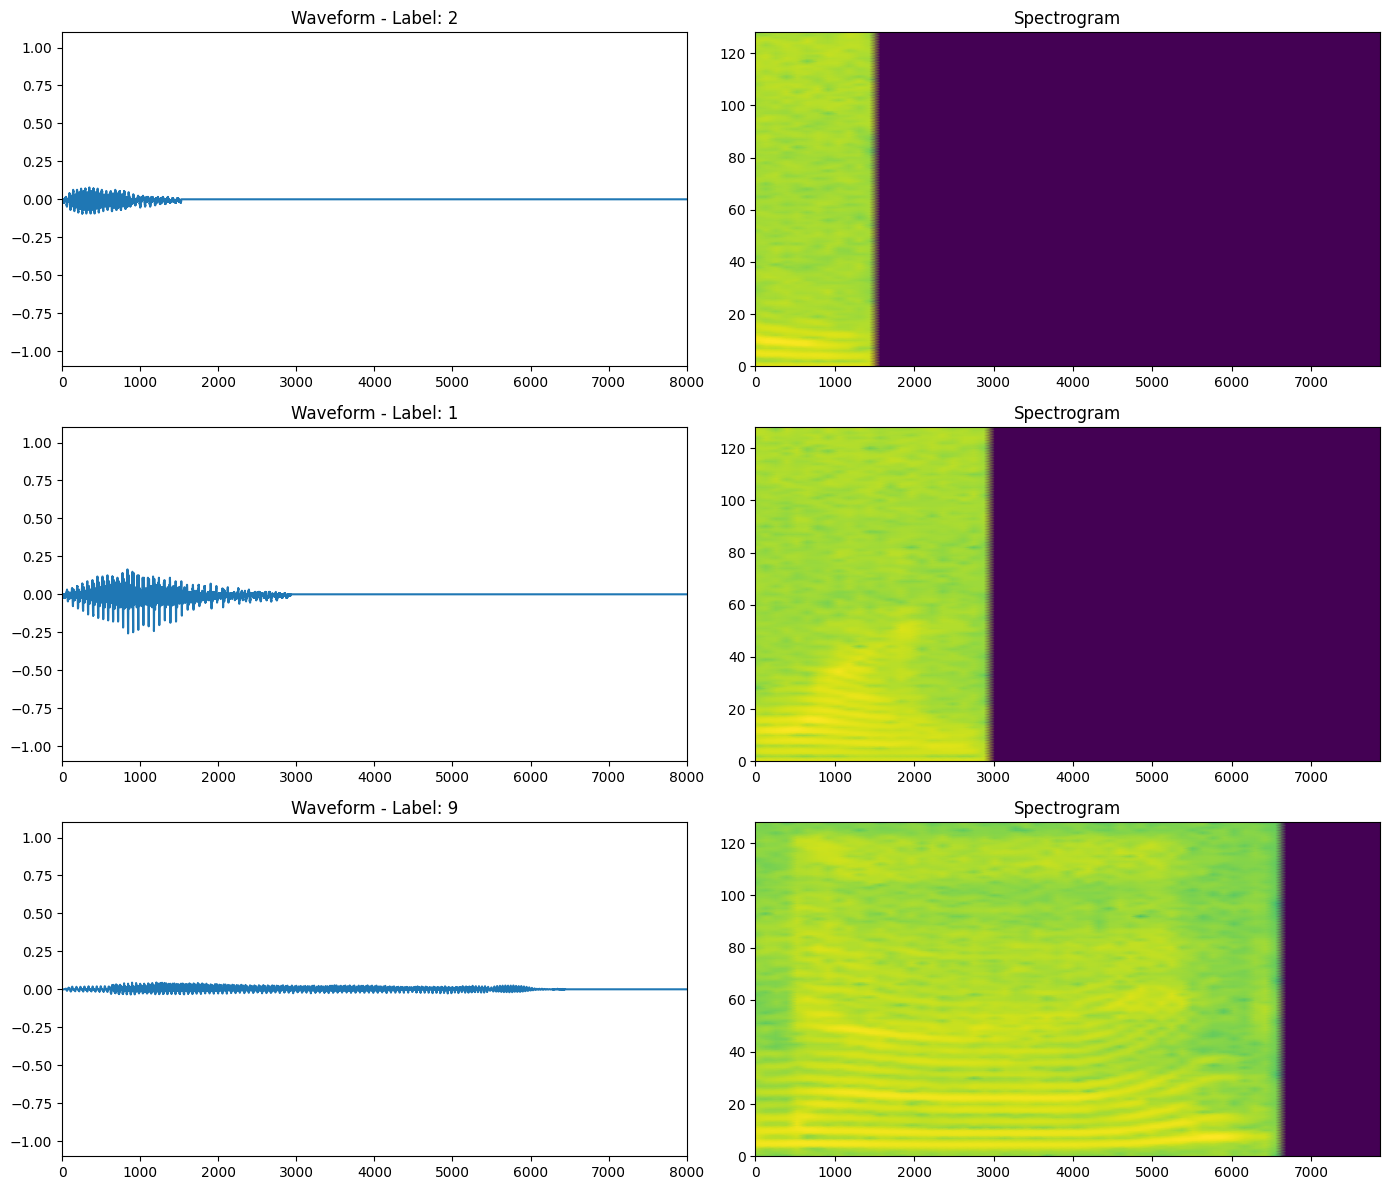

In [ ]:
# Visualización
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for i in range(3):
    waveform = example_audios[i]
    label = label_names[example_labels[i]]
    spectrogram = get_spectrogram(waveform)

    # Forma de onda
    timescale = np.arange(waveform.shape[0])
    axes[i, 0].plot(timescale, waveform.numpy())
    axes[i, 0].set_title(f'Waveform - Label: {label}')
    axes[i, 0].set_xlim([0, LONG_HZ])
    axes[i, 0].set_ylim([-1.1, 1.1])

    # Espectrograma
    plot_spectrogram(spectrogram.numpy(), axes[i, 1])
    axes[i, 1].set_title('Spectrogram')

    # Audio playback (solo del primer ejemplo para no saturar)
    if i == 0:
        ipy_display(display.Audio(waveform.numpy(), rate=LONG_HZ))

plt.tight_layout()
plt.show()

## Crear datasets con los espectogramas

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
BATCH_SIZE = 16
train_spectrogram_ds = make_spec_ds(df_train).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_spectrogram_ds = make_spec_ds(df_val).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
# Examinar espectogramas para los distintos ejemplos del dataset
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

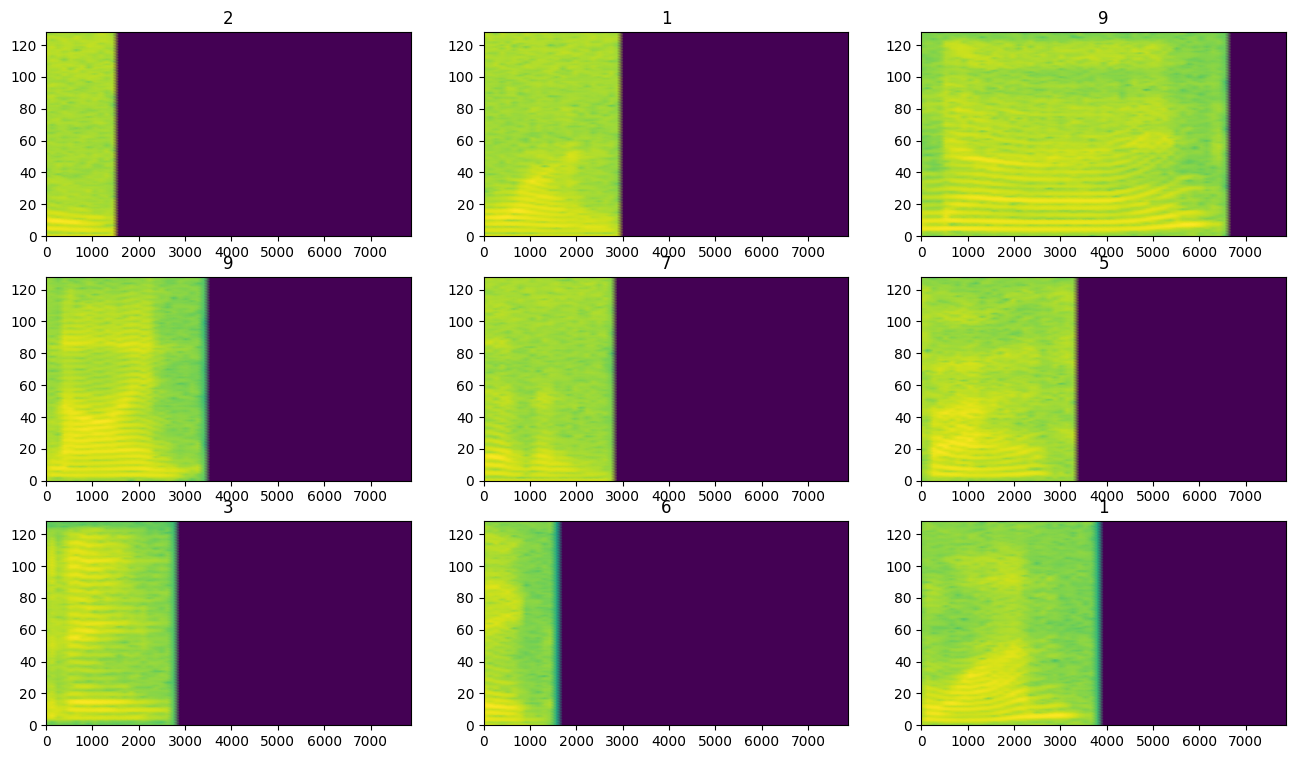

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

## Modelo convolucional

TRABAJA CON IMÁGENES 2D (ESPECTOGRAMAS)

### Optimizar la carga del dataset

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### Definición del modelo

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])
model.summary()

Input shape: (61, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
# Compilación
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

### Entrenamiento

In [ ]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.3250 - loss: 1.9203 - val_accuracy: 0.6840 - val_loss: 1.1008
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.6513 - loss: 1.1033 - val_accuracy: 0.8020 - val_loss: 0.7424
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - accuracy: 0.7538 - loss: 0.7586 - val_accuracy: 0.8620 - val_loss: 0.4402
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.8369 - loss: 0.5297 - val_accuracy: 0.8720 - val_loss: 0.3870
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.8704 - loss: 0.4430 - val_accuracy: 0.9300 - val_loss: 0.2855
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.9009 - loss: 0.3260 - val_accuracy: 0.9440 - val_loss: 0.2298
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9217 - loss: 0.2766 - val_accuracy: 0.9320 - val_loss: 0.2095
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - accuracy: 0.9127 - loss: 0.2561 - 

### Evaluación

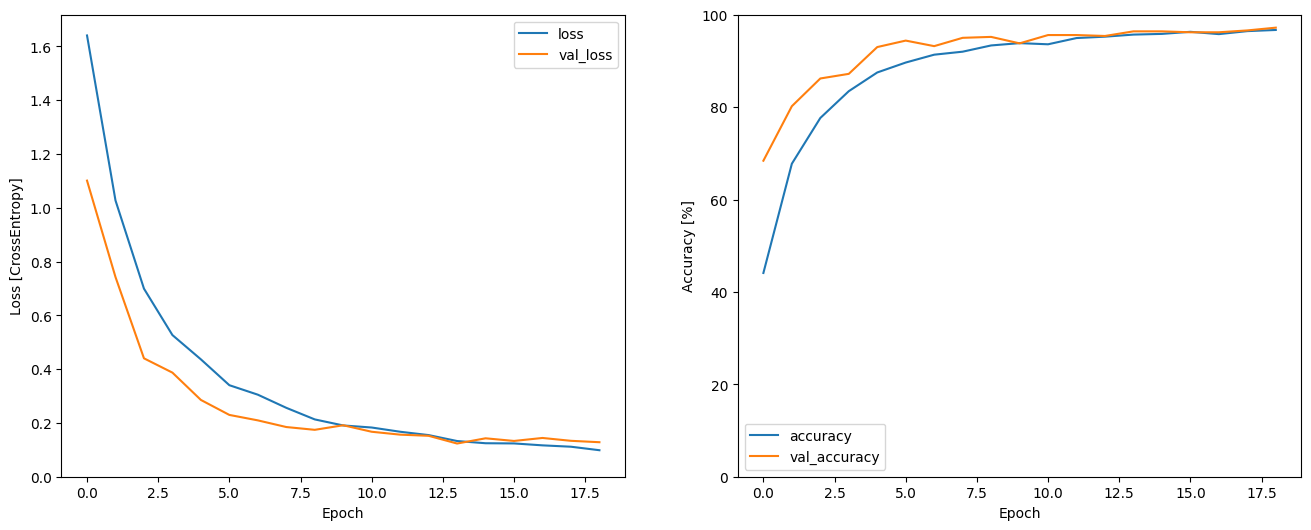

In [ ]:
# Visualización
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])

plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


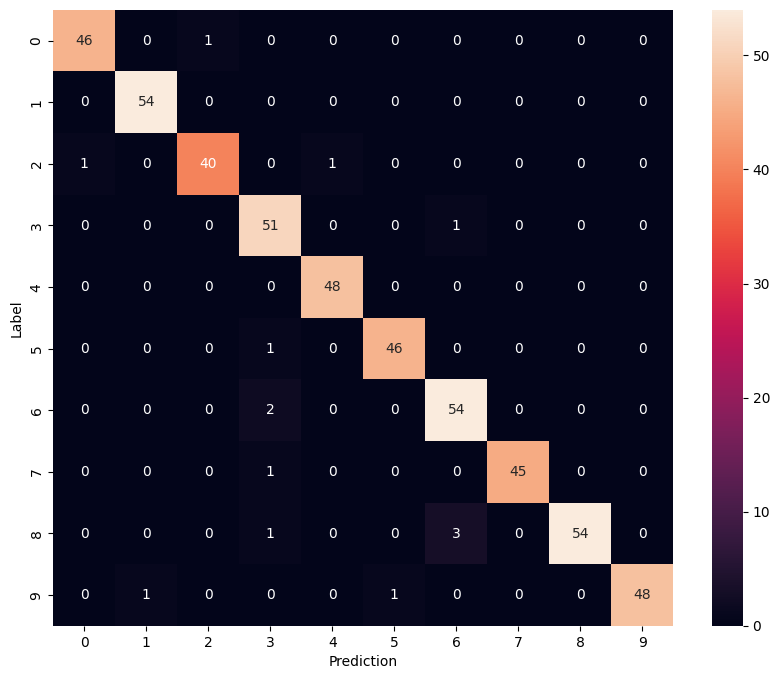

In [ ]:
# matriz de confusión para veificar qué tan bien clasificó el modelo
y_pred = model.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Inferir sobre un archivo de audio

In [ ]:
# debería usar el conjunto de val
# pasar por squeeze
# convertir a espectograma
# y por ultimo inferir en el modelo a ver que tal funciona

## Modelo recurrente

(TRABAJA CON VECTORES)

### Preparación del dataset

Sacamos el canal que no es necesario para este modelo

In [ ]:
def remove_channel(spectrogram, label):
    spectrogram = tf.squeeze(spectrogram, axis=-1)  # quita el canal de tamaño 1
    return spectrogram, label

In [ ]:
train_rnn = train_spectrogram_ds.map(remove_channel)
val_rnn = val_spectrogram_ds.map(remove_channel)

In [ ]:
# Revisar la forma de un batch
for batch_x, batch_y in train_rnn.take(1):
    print(batch_x.shape)  # debería ser (BATCH_SIZE, timesteps, features)

(16, 61, 129)


### Optimizar la carga del Dataset

In [ ]:
train_rnn = train_rnn.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_rnn = val_rnn.cache().prefetch(tf.data.AUTOTUNE)

### Definición del modelo

In [ ]:
# Normalización - adaptá usando muestras del dataset sin canal
batch_specs = []
for spec, _ in train_rnn.take(100):  # spec shape: (batch_size, timesteps, features)
    batch_specs.append(spec.numpy())
batch_specs = np.concatenate(batch_specs, axis=0)  # concatena todos los batchs en una sola dimensión de samples

norm_layer = layers.Normalization()
norm_layer.adapt(batch_specs)

# Input shape
example_spectrograms = next(iter(train_rnn.take(1)))[0]  # (batch_size, timesteps, features)
input_shape_rnn = example_spectrograms.shape[1:]        # (timesteps, features)

# Modelo
rnn_model = models.Sequential([
    layers.Input(shape=input_shape_rnn),
    norm_layer,
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_labels),
])

In [ ]:
# Compilación
rnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### Entrenamiento

In [ ]:
# Entrenamiento
EPOCHS = 50
history_rnn = rnn_model.fit(
    train_rnn,
    validation_data=val_rnn,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.0987 - loss: 2.3162 - val_accuracy: 0.0940 - val_loss: 2.3043
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 65ms/step - accuracy: 0.0950 - loss: 2.3043 - val_accuracy: 0.0840 - val_loss: 2.3047
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.1029 - loss: 2.3031 - val_accuracy: 0.0840 - val_loss: 2.3039
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.1062 - loss: 2.3028 - val_accuracy: 0.0840 - val_loss: 2.3070
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.1098 - loss: 2.3056 - val_accuracy: 0.0840 - val_loss: 2.3035
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.1072 - loss: 2.3025 - val_accuracy: 0.0940 - val_loss: 2.3034
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.0945 - loss: 2.3042 - val_accuracy: 0.1000 - val_loss: 2.3084
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.0942 - loss: 2.3034 - va

### Evaluación

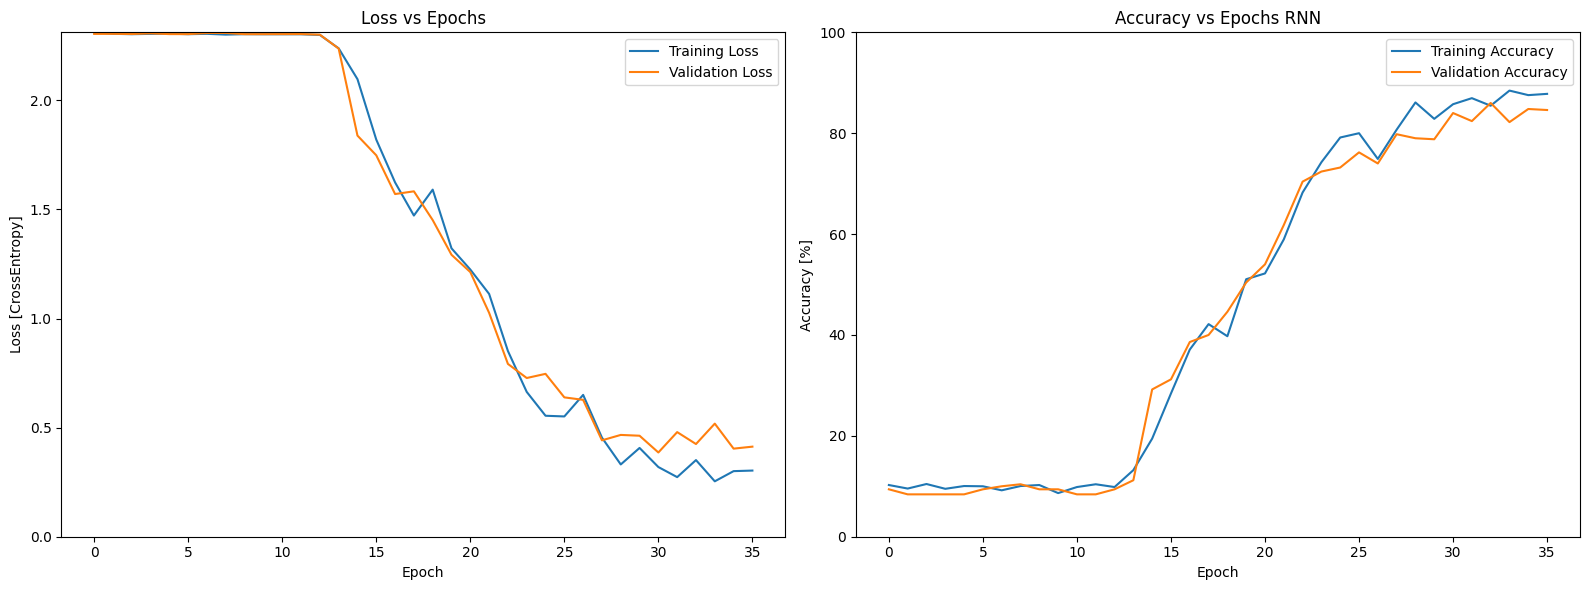

In [ ]:
# Evaluación
metrics = history_rnn.history

plt.figure(figsize=(16, 6))

# Gráfico de pérdida (loss)
plt.subplot(1, 2, 1)
plt.plot(history_rnn.epoch, metrics['loss'], label='Training Loss')
plt.plot(history_rnn.epoch, metrics['val_loss'], label='Validation Loss')
plt.legend()
plt.ylim([0, max(max(metrics['loss']), max(metrics['val_loss']))])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.title('Loss vs Epochs')

# Gráfico de precisión (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history_rnn.epoch, 100 * np.array(metrics['accuracy']), label='Training Accuracy')
plt.plot(history_rnn.epoch, 100 * np.array(metrics['val_accuracy']), label='Validation Accuracy')
plt.legend()
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.title('Accuracy vs Epochs RNN')

plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


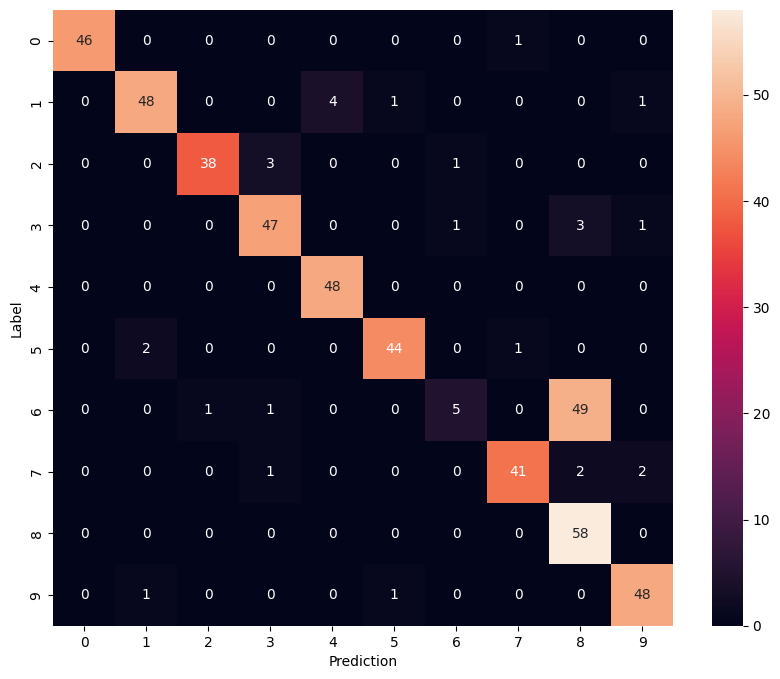

In [ ]:
# Confusion matrix
y_pred_rnn = rnn_model.predict(val_rnn)
y_pred_rnn = tf.argmax(y_pred_rnn, axis=1)
y_true_rnn = tf.concat(list(val_rnn.map(lambda s, lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true_rnn, y_pred_rnn)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Inferir sobre un archivo de audio